<a name="top"></a>
<br/>
# TP3 - Variables selection with Ridge and Lasso penalization

**High-dimensional statistics** by [Anne Gégout-Petit](http://www.iecl.univ-lorraine.fr/~Anne.Gegout/).

Authors: [Sylvain Combettes](https://sylvaincom.github.io/) and Lucas Lherbier. <br/>
Last update: Oct 14, 2019. Creation: Oct 1, 2019.

Tutorial: [Running R on Jupyter Notebook](https://docs.anaconda.com/anaconda/navigator/tutorials/create-r-environment/).

---
### Imports

In [1]:
library(MASS)
library(ElemStatLearn)
library(glmnet)
library(psych)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



We configure the size of the plots:

In [2]:
library(repr)
options(repr.plot.width=7, repr.plot.height=5)

---
# 1) Ridge regression - Simulations

---
## Question 1.1)

In [3]:
set.seed(123) # create a seed for reproducability

x1 = rnorm(20)
x2 = rnorm(20, mean=x1, sd=.01)
x = cbind(x1, x2)
n = dim(x)[1]
p = dim(x)[2]
y = rnorm(20, mean=3+x1+x2)

In [4]:
# help(lm.ridge)

In [5]:
lm.ridge(y~x1+x2, lambda=1) # gives the coefficients of the model
lm(y~x1+x2)$coef # classic regression without penalization
lm.ridge(y~x1+x2, lambda=0) # same as without penalization because lambda=0
# lm.ridge(y~x1+x2, lambda=1)

                 x1        x2 
3.1303309 0.9080373 0.9233121 

(Intercept)          x1          x2 
   3.127965   -9.155559   11.040228

                 x1        x2 
 3.127965 -9.155559 11.040228 

We now want to retrieve our coefficients in order to do a prediction:

In [6]:
lr = lm.ridge(y~x1+x2, lambda=1)
lr$coef

x1        x2 
0.8608529 0.8746805

However, we do not have the same coefficients although we use the same method with the same `lm.ridge` function! It is a little bit confusing! Actually, we should not forget that Ridge works on centered and scaled variables. `lr$coef` gives the coefficients that have to be applied on scaled variables. Scales are given with:

In [7]:
lr$scales

x1        x2 
0.9480369 0.9473292

and we retrieve the same value for the coefficients as in `lm.ridge(y~x1+x2, lambda=1)` with:

In [8]:
(lr$coef)/(lr$scales)

x1        x2 
0.9080373 0.9233121

However, we do not have $\beta_0$. We can retrieve $\beta_0$ trough the mean of $X$ and $Y$ with:

In [9]:
lr$xm # column means of x matrix
lr$ym # mean of y

x1        x2 
0.1416238 0.1411112

[1] 3.38922

<span style="background-color: lightblue"> _Remark 1:_ We do not understand how we can retrieve the value of $\beta_0$ through `lr$xm` and `lr$ym`. </span>

A way to compute the previsions for each entries of $y$ by the model is the following:

In [10]:
veccoef = (lr$coef) / (lr$scales)
vecprev = ( (x - lr$xm*(matrix(rep(1,n*p),ncol=p))) %*% veccoef) + lr$ym # vector of previsions (estimate of Y)

# so that is is possible to compute the residuals and the RSS
resid = vecprev - y
RSS = t(resid) %*% resid

#lm.ridge can be performed for a several values of lambda together
lm.ridge(y~x1+x2, lambda=c(1,2,3))

                  x1        x2
1 3.130331 0.9080373 0.9233121
2 3.136494 0.8898884 0.8978541
3 3.142371 0.8703238 0.8758418

<span style="background-color: lightblue"> _Remark 2:_ We do not understand the formula of `vecprev`. </span>

In [11]:
lr = lm.ridge(y~x1+x2, lambda=c(1,2,3))
lr$coef

,1,2,3
x1,0.8608529,0.8436471,0.8250990
x2,0.8746805,0.8505634,0.8297105


so that it is possible to compute RSS for each values of lambda to compute the AIC you have to compute the df according to the formula given in the lecture

In [12]:
lambda = 2
H = x %*% solve( t(x)%*%x + lambda*diag(rep(1,p)) ) %*% t(x)
df = sum(diag(H))
df

[1] 0.9486763

---
## Question 1.2)

In [13]:
x1 = rnorm(20)
x2 = rnorm(20, mean=x1, sd=.01)
x = cbind(x1, x2)
y = rnorm(20, mean=3+x1+x2)
lm(y~x1+x2)$coef

(Intercept)          x1          x2 
   2.556645  -20.835232   22.817402

In [14]:
lr = lm.ridge(y~x1+x2)
lm.ridge(y~x1+x2, lambda=0)

                   x1         x2 
  2.556645 -20.835232  22.817402 

In [15]:
sr = simple.ridge(x, y, lambda=seq(0,1,0.05))
sr

,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1
x1,-20.27489,0.666859,0.8070437,0.853368,0.8759912,0.8890973,0.8974358,0.9030472,0.9069537,0.9097238,...,0.9130964,0.9140614,0.9146941,0.9150666,0.9152312,0.9152277,0.9150861,0.9148299,0.9144777,0.9140444
x2,22.18070,1.236440,1.0937573,1.044942,1.0198337,1.0042494,0.9934392,0.9853624,0.9789970,0.9737744,...,0.9655158,0.9621174,0.9590574,0.9562641,0.9536848,0.9512799,0.9490193,0.9468794,0.9448416,0.9428911


As soon as $\lambda>0.1$, the estimation of the coefficient is not so bad and is definitely better than when $\lambda=0$. As $\lambda=0$ means that we are actually performing a standard regression, the Ridge regression is better than the standard regression. We see that we penalize the values of the coefficients.

---
## Question 1.3)

We create the `beta` coefficients:

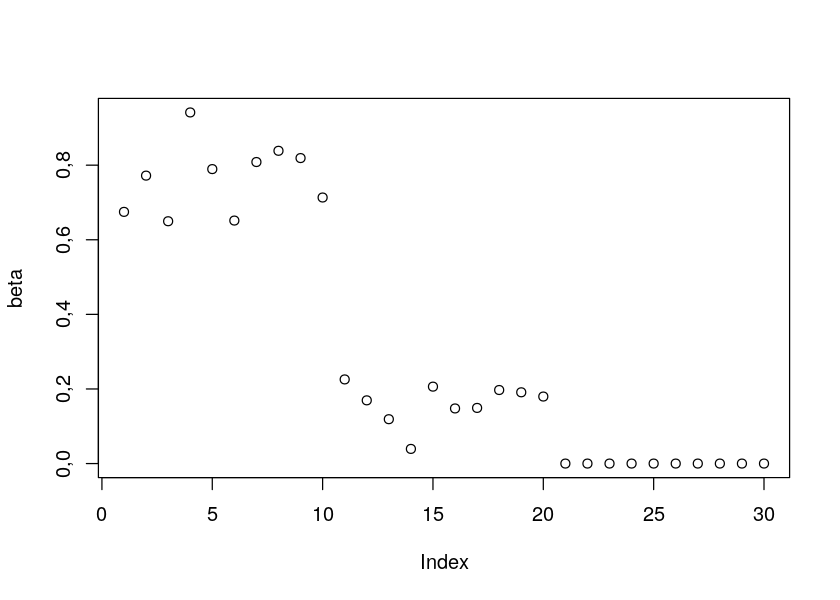

In [16]:
set.seed(1) # create a seed for reproducability
beta = rep(0, 30)
beta[1:10] = rnorm(length(1:10), mean=0.75, sd=0.12)
beta[11:20] = rnorm(length(11:20), mean=0.15, sd=0.05)
plot(beta)

We create `X`, then `Y` according to `X` and `beta`:

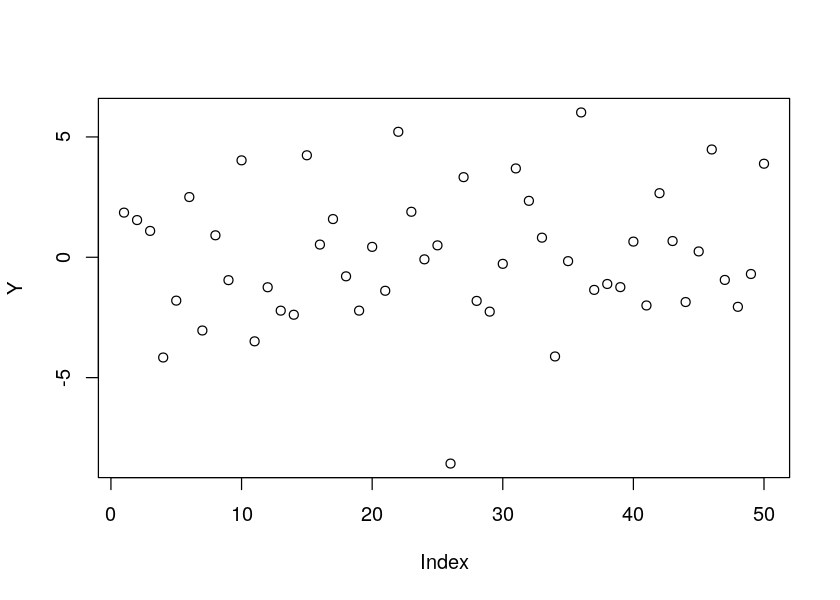

In [17]:
n = 50
p = 30
sd = 0.5
X = matrix(rnorm(n*p, mean=0, sd=1), n, p)
Y = rnorm(50, mean = X%*%beta, sd=sd)

plot(Y)

---
## Question 1.4)

We take a given value of $\lambda$.

According to the lecture, the estimate of the variance matrix of the ridge regression is:

\begin{equation}
    \mathrm{Var}\left(\widehat{\beta}^{\text{ridge}}\right) = \sigma^2 W X' X W \quad \in \mathcal{M}_{p,p}
\end{equation}

where $W = (X'X+\lambda I)^{-1} \in \mathcal{M}_{p,p}$. The total variance is:

\begin{equation}
    \sum_{j=1}^{p} \mathrm{Var}\left(\widehat{\beta}_j^{\text{ridge}}\right) = \mathrm{trace}\left( \mathrm{Var}\left(\widehat{\beta}^{\text{ridge}}\right)\right) \quad \in \mathbb{R}
\end{equation}

The estimate of the bias vector of the ridge regression is:

\begin{equation}
    \mathrm{Bias}\left(\widehat{\beta}^{\text{ridge}}\right) = - \lambda W \beta \quad \in \mathbb{R}^p
\end{equation}

The total squared bias is:

\begin{equation}
    \sum_{j=1}^{p} \mathrm{Bias}^2\left(\widehat{\beta}_j^{\text{ridge}}\right) = \mathrm{Bias}\left(\widehat{\beta}^{\text{ridge}}\right)'\mathrm{Bias}\left(\widehat{\beta}^{\text{ridge}}\right) \quad \in \mathbb{R}
\end{equation}

Note: `solve` of a matrix gives the inverse.

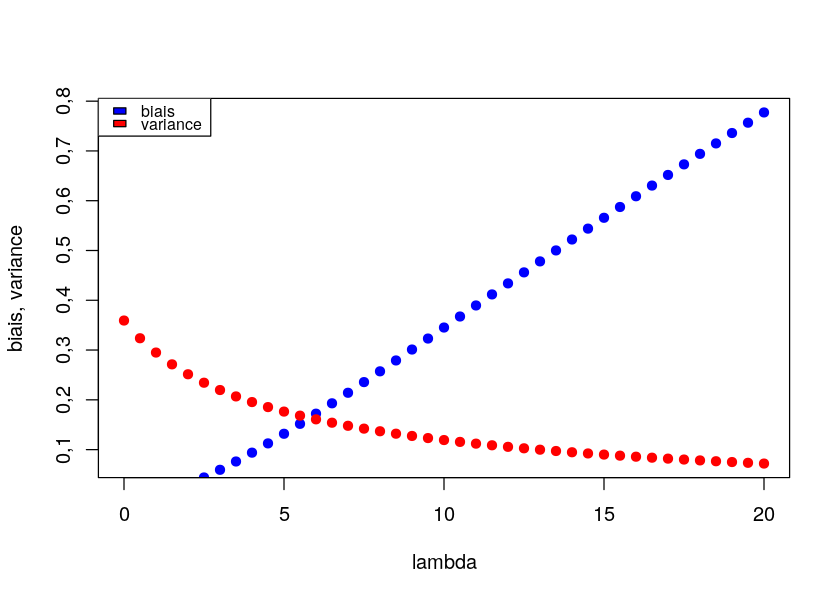

In [18]:
l_var = NULL
l_biais = NULL
l_lambda = seq(0, 20, 0.5)

for (lambda_i in l_lambda){
  W = solve(t(X)%*%X + lambda_i*diag(p))
  var = tr( sd^2 * W %*% t(X) %*% X %*% W )
  l_var = cbind(l_var, var)
  biais = t(- lambda_i * W %*% beta) %*% (- lambda_i * W %*% beta)
  l_biais = cbind(l_biais, biais)
}

plot(l_lambda, l_biais, pch=19, col="blue", ylim = c(min(biais,var), max(biais,var)), xlab="lambda",
     ylab="biais, variance")
points(l_lambda, l_var, pch=19, col="red")
legend("topleft", legend=c("biais", "variance"), fill=c("blue", "red"), cex=0.8)

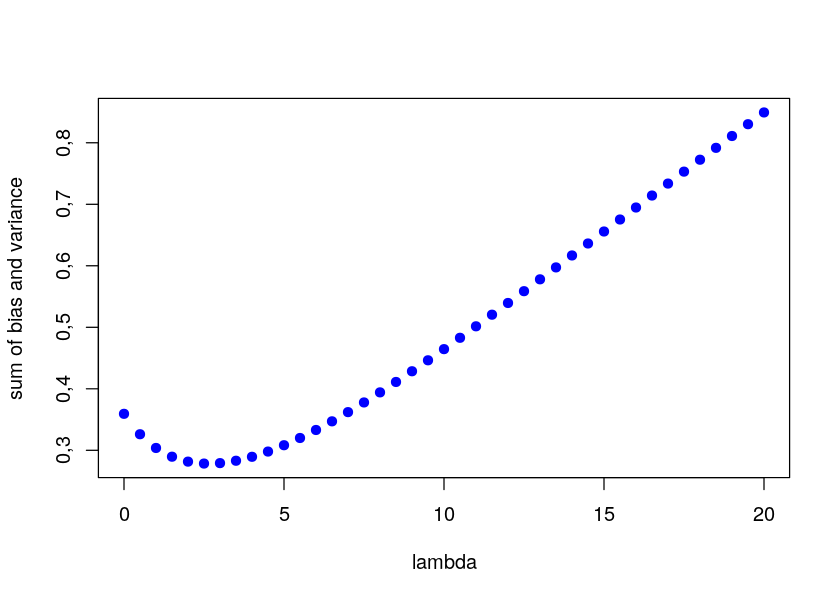

In [19]:
l_sum = l_biais + l_var
plot(l_lambda, l_sum, pch=19, col="blue", ylim = c(min(l_sum), max(l_sum)), xlab="lambda",
     ylab="sum of bias and variance")

The best value of $\lambda$ being the minimum of the sum of the bias and the variance, we find that the best value of $\lambda$ is:

In [20]:
best_lambda = l_lambda[which.min(l_sum)]
best_lambda

[1] 2,5

---
## Question 1.5)

[1] 1

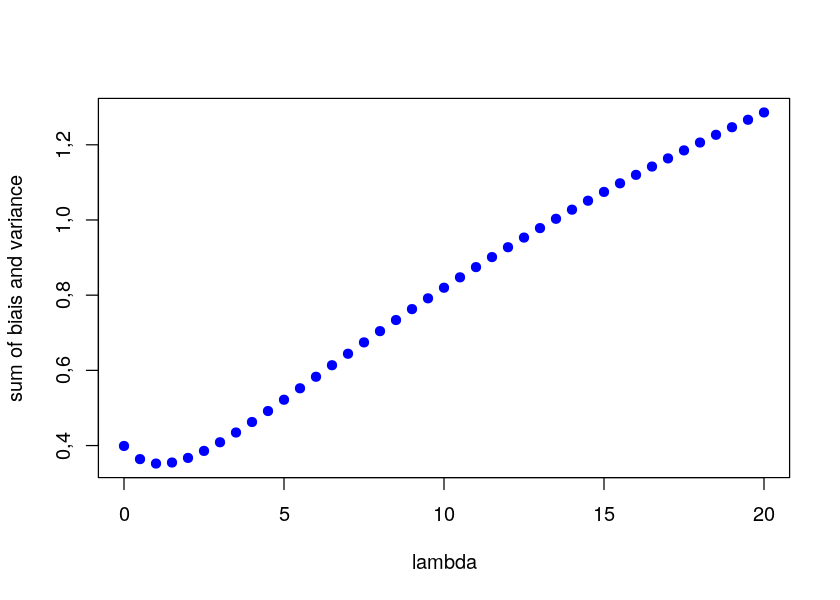

In [21]:
set.seed(111) # create a seed for reproducability
beta = rep(0, 30)
beta[1:10] = rnorm(length(1:10), mean=0.75, sd=0.2)
#plot(beta)
n = 50
p = 30
sd = 0.5
X = matrix(rnorm(n*p, mean=0, sd=1), n, p)
Y = rnorm(50, mean = X%*%beta, sd=sd)
#plot(Y)

l_var = NULL
l_biais = NULL
l_lambda = seq(0, 20, 0.5)

for (lambda_i in l_lambda){
  W = solve(t(X)%*%X + lambda_i*diag(p))
  var = tr( sd^2 * W %*% t(X) %*% X %*% W )
  l_var = cbind(l_var, var)
  biais = t(- lambda_i * W %*% beta) %*% (- lambda_i * W %*% beta)
  l_biais = cbind(l_biais, biais)
}

#plot(l_lambda, l_biais, pch=19, col="blue", ylim = c(min(biais,var), max(biais,var)), xlab="lambda",
#    ylab="variance, biais")
#points(l_lambda, l_var, pch=19, col="red")
#legend("topleft", legend=c("biais", "variance"), fill=c("blue", "red"), cex=0.8)

l_sum = l_biais + l_var

plot(l_lambda, l_sum, pch=19, col="blue", ylim = c(min(l_sum), max(l_sum)), xlab="lambda",
     ylab="sum of biais and variance")

best_lambda = l_lambda[which.min(l_sum)]
best_lambda

---
## Question 1.6

The degrees of freedom are given by:

\begin{equation}
    df(\lambda) = \mathrm{trace}\left( (X'X+\lambda I)^{-1} X' \right) = W X'
\end{equation}

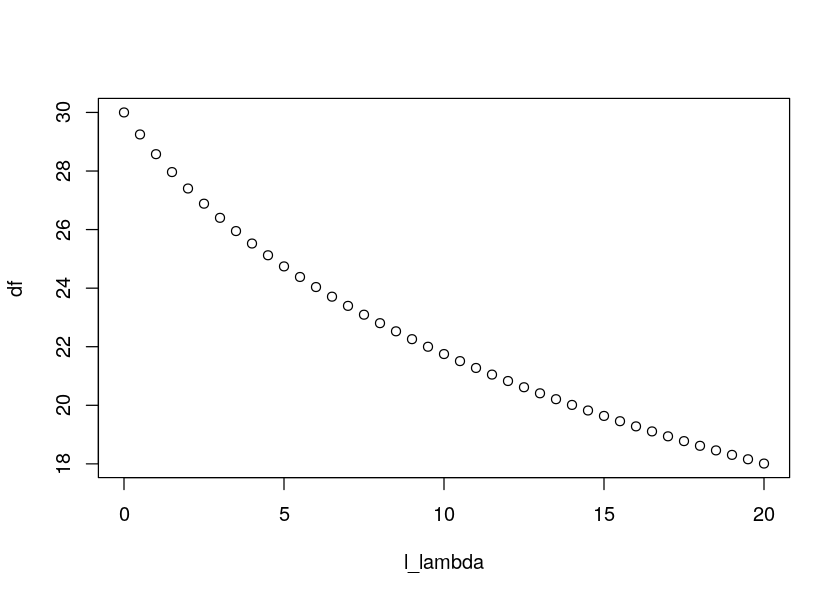

In [22]:
df = rep(1, length(l_lambda))

for (i in 1:length(l_lambda))
{
    lambda_i = l_lambda[i]
    H = X %*% solve( t(X)%*%X + lambda_i*diag(rep(1,p)) ) %*% t(X)
    df[i] = sum(diag(H))
}

plot(l_lambda, df)

With the implemented R function:

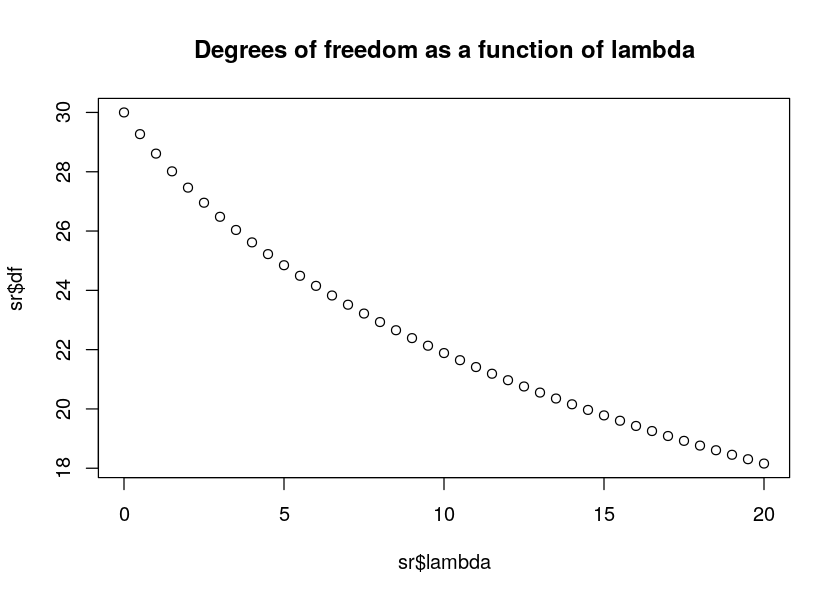

In [23]:
sr = simple.ridge(X,Y, lambda=seq(0,20,0.5))

plot(sr$lambda,sr$df, main='Degrees of freedom as a function of lambda')
#plot(sr$lambda,sr$beta[1,], main='x1 coefficient as a function of lambda')
#plot(sr$lambda,sr$beta[2,], main='x2 coefficient as a function of lambda')

---
## Question 1.7)

During the lecture, it was said to not do this question.

---
## Question 1.8)

In [24]:
# help(cv.glmnet)

[1] 0,1

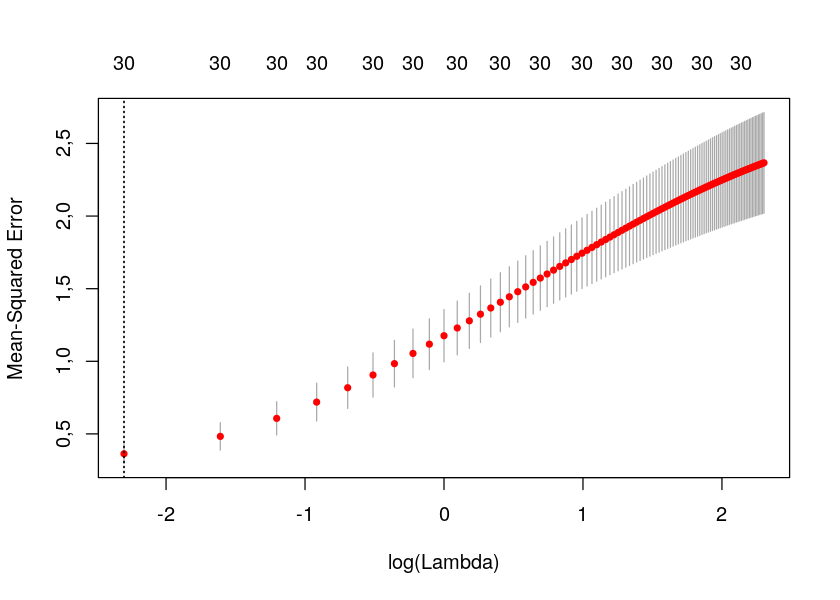

In [25]:
cv = cv.glmnet(X, Y, alpha = 0, nfolds = 10, lambda=seq(0, 10, 0.1))
plot(cv)
cv$lambda.min

---
## Question 1.9) and 1.10)

During the lecture, it was said to not do these questions.

---
# 2) Real data set prostate

---
## Question 2.1)

We import the dataset:

In [26]:
dataset = read.table(file='prostate.txt', sep="\t", header=TRUE, dec=".")
dim(dataset)
head(dataset)

[1] 97 10

Id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
1,"-0,5798185","2,769459",50,"-1,386294",0,"-1,386294",6,0,"-0,4307829"
2,"-0,9942523","3,319626",58,"-1,386294",0,"-1,386294",6,0,"-0,1625189"
3,"-0,5108256","2,691243",74,"-1,386294",0,"-1,386294",7,20,"-0,1625189"
4,"-1,2039728","3,282789",58,"-1,386294",0,"-1,386294",6,0,"-0,1625189"
5,"0,7514161","3,432373",62,"-1,386294",0,"-1,386294",6,0,"0,3715636"
6,"-1,0498221","3,228826",50,"-1,386294",0,"-1,386294",6,0,"0,7654678"


---
## Question 2.2)

We build the matrix of covariates $X$ and we build the target $Y$:

In [27]:
X = matrix(rep(NA,8*97), ncol=8) # initialization
for (j in (2:9))
{
    X[,j-1] = dataset[,j]
}
Y = dataset[,10]
colnames(X) = colnames(dataset[,2:9])

head(X)
head(Y)

lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
"-0,5798185","2,769459",50,"-1,386294",0,"-1,386294",6,0
"-0,9942523","3,319626",58,"-1,386294",0,"-1,386294",6,0
"-0,5108256","2,691243",74,"-1,386294",0,"-1,386294",7,20
"-1,2039728","3,282789",58,"-1,386294",0,"-1,386294",6,0
"0,7514161","3,432373",62,"-1,386294",0,"-1,386294",6,0
"-1,0498221","3,228826",50,"-1,386294",0,"-1,386294",6,0


[1] -0,4307829 -0,1625189 -0,1625189 -0,1625189  0,3715636  0,7654678

In [28]:
# help(glmnet) # alpha=1 is the lasso penalty, and alpha=0 the ridge penalty

We apply Ridge with `glmnet`:

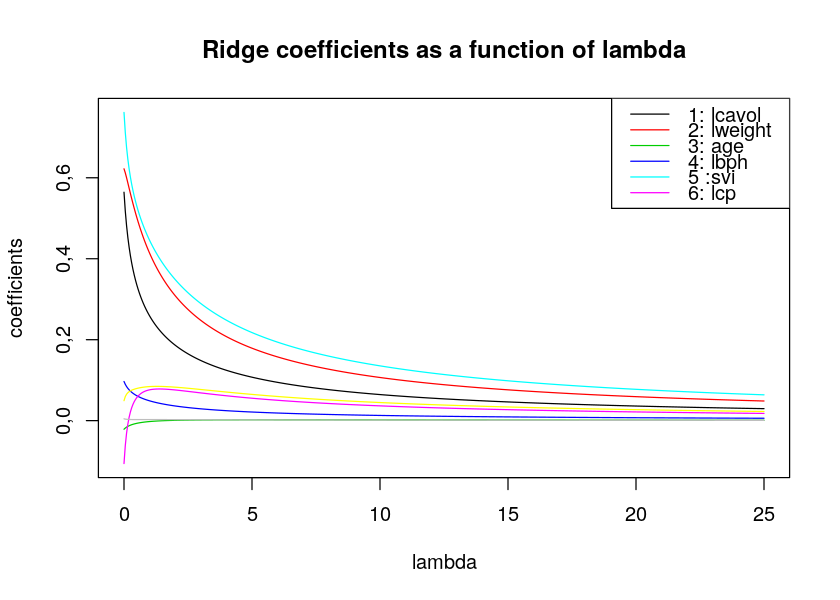

In [29]:
fit_ridge = glmnet(X, Y, alpha=0, lambda = seq(0, 25, 0.05)) ;
matplot(fit_ridge$lambda, t(fit_ridge$beta), type="l", lty = 1, lwd = 1, col=1:8,
        xlab="lambda", ylab="coefficients", main="Ridge coefficients as a function of lambda")
legend("topright", c("1: lcavol", "2: lweight", "3: age", "4: lbph", "5 :svi", "6: lcp"), lwd=1, col=1:8)

We observe that Ridge does not put all the coefficients to $0$, on the contrary of Lasso. We have no intereseting elbow plot. We always have a `df` of 8, thus 8 non null coefficients:

In [30]:
summary(fit_ridge$df)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      8       8       8       8       8       8 

We apply Lasso with `glmnet`, the commands are the almost the same as for Ridge:

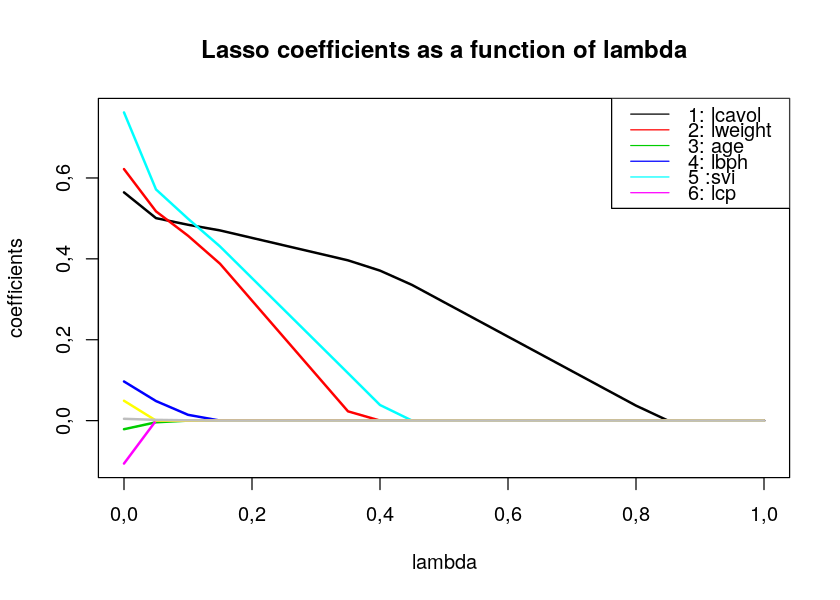

In [31]:
fit_lasso = glmnet(X, Y, alpha=1, lambda = seq(0, 1, 0.05)) ;
matplot(fit_lasso$lambda, t(fit_lasso$beta), type="l", lty = 1, lwd = 2, col=1:8,
        xlab="lambda", ylab="coefficients", main="Lasso coefficients as a function of lambda")
legend("topright", c("1: lcavol", "2: lweight", "3: age", "4: lbph", "5 :svi", "6: lcp"), lwd=1, col=1:8)

Lasso puts the coefficients to $0$.

`glmnet` can compute `df` for Lasso:

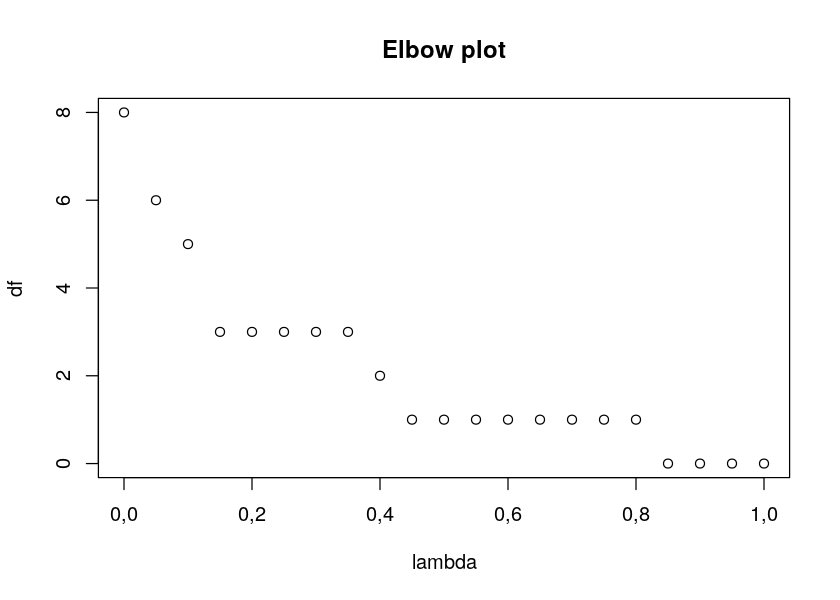

In [32]:
plot(fit_lasso$lambda, fit_lasso$df, xlab="lambda", ylab="df", main="Elbow plot")

We choose $\lambda=0.15$.

---
## Question 2.3)

For Ridge:

[1] 0,1

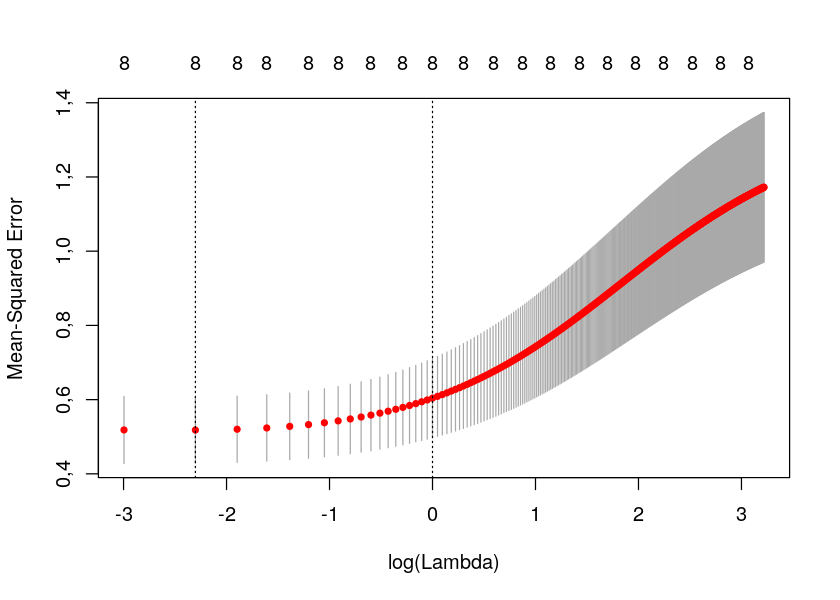

In [33]:
cv = cv.glmnet(X, Y, alpha = 0, nfolds = 10, lambda=fit_ridge$lambda)
plot(cv)
cv$lambda.min

For Lasso:

[1] 0,1

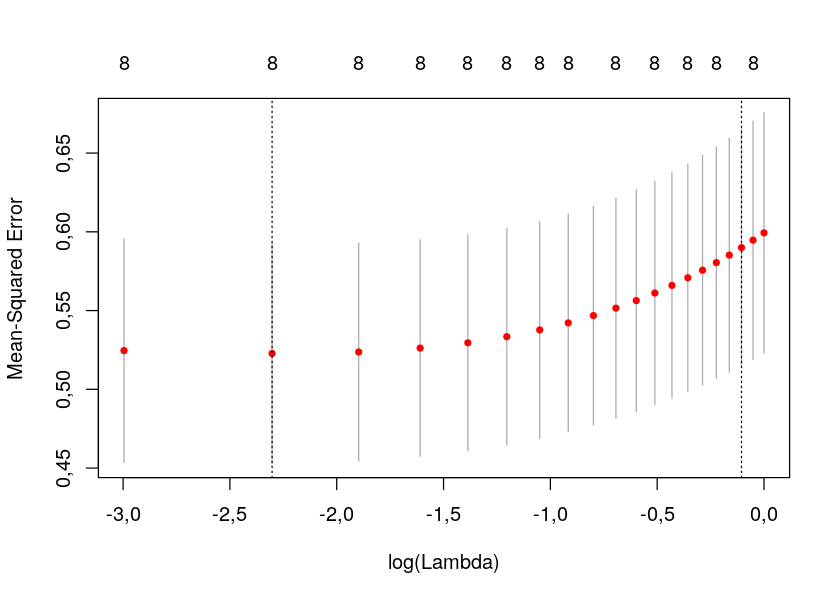

In [34]:
cv = cv.glmnet(X, Y, alpha = 0, nfolds = 10, lambda=fit_lasso$lambda)
plot(cv)
cv$lambda.min

---
# 3) Real data set Birth

---
## Question 3.1)

In [35]:
dataset = read.table(file='birth.txt', sep="\t", header=TRUE, dec=".")
dim(dataset)
head(dataset)

[1] 189  11

ID,AGE,LWT,POIDS,SMOKE,PTL,HT,UI,FVT,BWT,low
85,19,182,"87,36",0,0,0,1,0,2523,1
86,33,155,"74,4",0,0,0,0,3,2551,1
87,20,105,"50,4",1,0,0,0,1,2557,1
88,21,108,"51,84",1,0,0,1,2,2594,1
89,18,107,"51,36",1,0,0,1,0,2600,1
91,21,124,"59,52",0,0,0,0,0,2622,1


---
## Question 3.2)

In [36]:
X = dataset[, c(2,4:9)]
head(X)
X = data.matrix(X)

Y = dataset[, 11]
head(Y)

AGE,POIDS,SMOKE,PTL,HT,UI,FVT
19,"87,36",0,0,0,1,0
33,"74,4",0,0,0,0,3
20,"50,4",1,0,0,0,1
21,"51,84",1,0,0,1,2
18,"51,36",1,0,0,1,0
21,"59,52",0,0,0,0,0


[1] 1 1 1 1 1 1

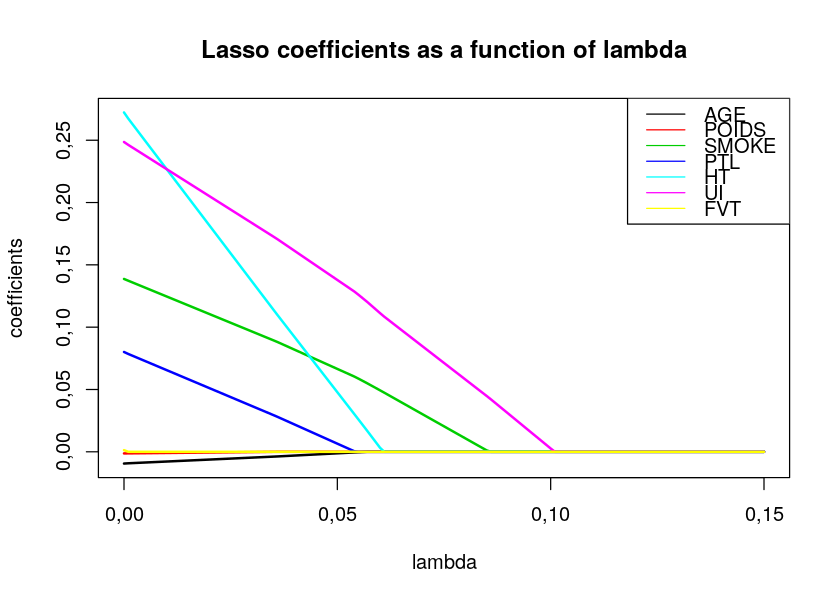

In [37]:
fit_lasso = glmnet(X, Y, alpha=1, lambda = seq(0, 0.15, 0.001)) ;
matplot(fit_lasso$lambda, t(fit_lasso$beta), type="l", lty = 1, lwd = 2, col=1:7,
        xlab="lambda", ylab="coefficients", main="Lasso coefficients as a function of lambda")
legend("topright", c('AGE', 'POIDS', 'SMOKE', 'PTL', 'HT', 'UI', 'FVT'), lwd=1, col=1:7)

[1] 0,016

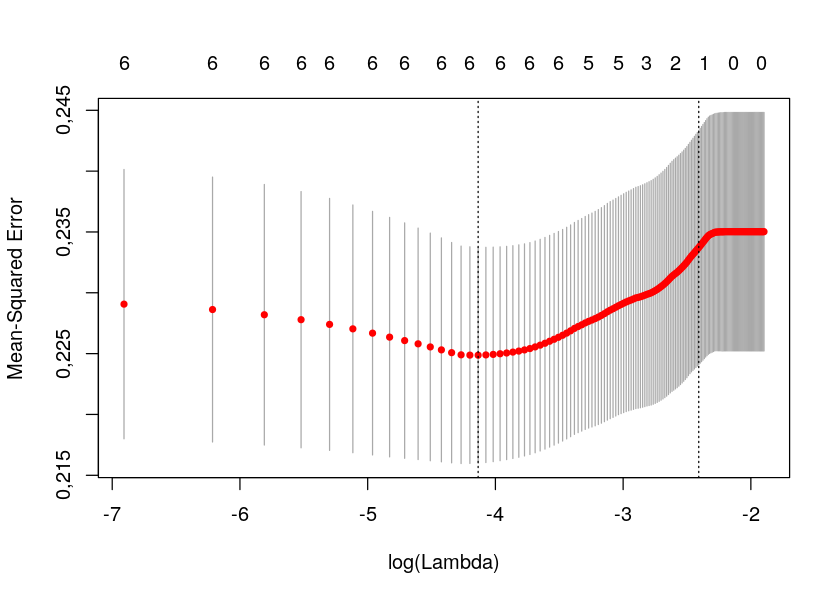

In [38]:
cv = cv.glmnet(X, Y, alpha = 1, nfolds = 10, lambda=fit_lasso$lambda)
plot(cv)
cv$lambda.min

---
## Question 3.3)

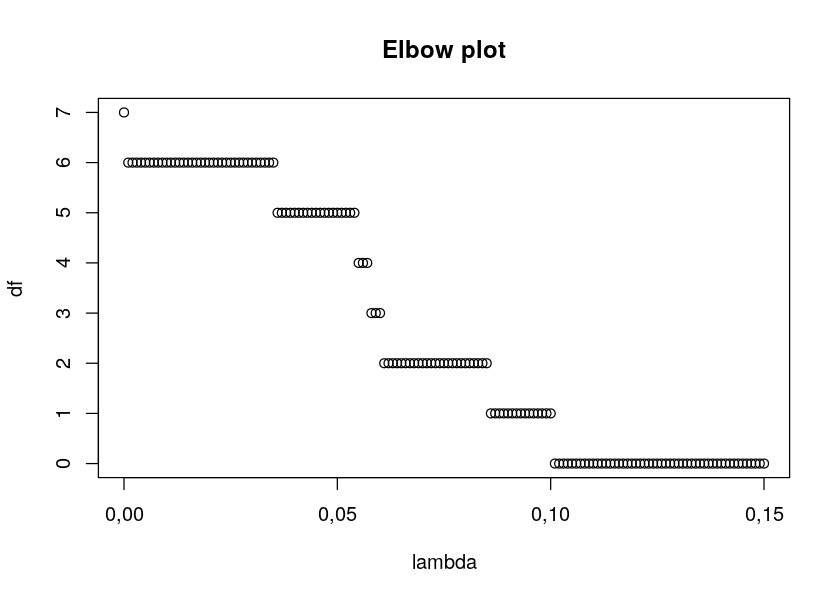

In [39]:
plot(fit_lasso$lambda, fit_lasso$df, xlab="lambda", ylab="df", main="Elbow plot")

---
# 4) Knockoff method

[1] 189  14

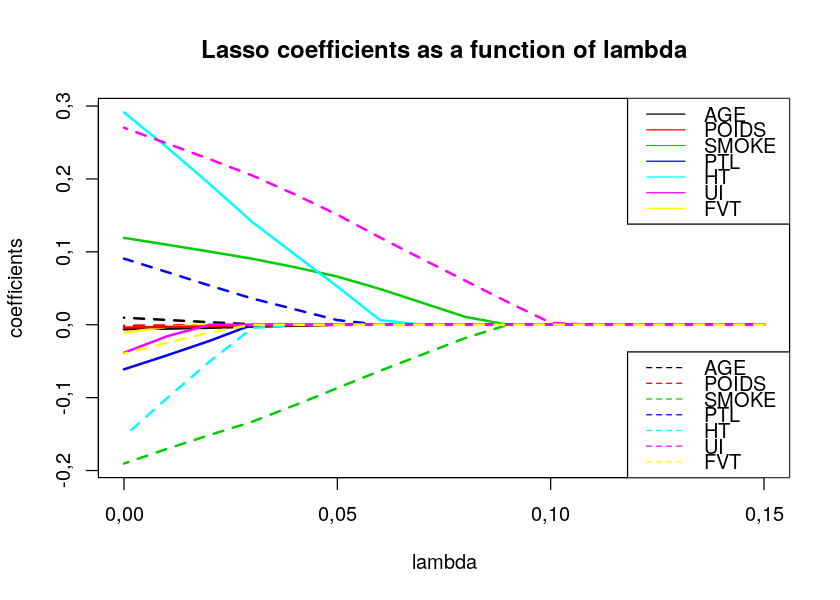

In [40]:
set.seed(34) # create a seed for reproducability

l = dim(X)[2]

X_permut = X[sample(1:dim(X)[1]),] # permutation
X_tot = cbind(X, X_permut)
dim(X_tot)

fit_lasso_tot = glmnet(X_tot, Y, alpha=1, lambda = seq(0,0.15,0.01))
col = cbind(seq(1:l), seq(1:l))

matplot(fit_lasso_tot$lambda, t(fit_lasso_tot$beta), type="l", lty = 1:2,
        lwd = 2, col=col, xlab="lambda", ylab="coefficients",
        main="Lasso coefficients as a function of lambda")

legend("topright", c('AGE', 'POIDS', 'SMOKE', 'PTL', 'HT', 'UI', 'FVT'), lwd=1, col=1:7)
legend("bottomright", c('AGE', 'POIDS', 'SMOKE', 'PTL', 'HT', 'UI', 'FVT'), lty=2, col=1:7)

Now, we plot each variable separately:

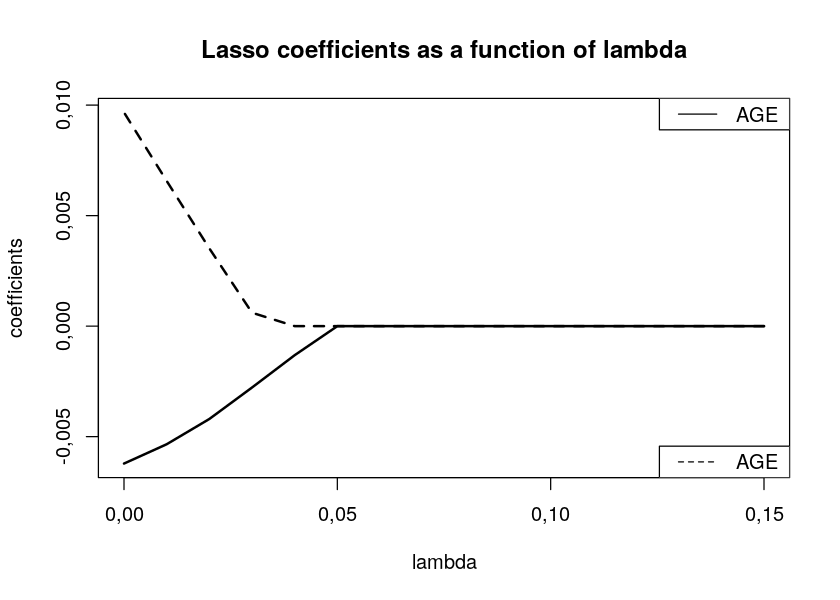

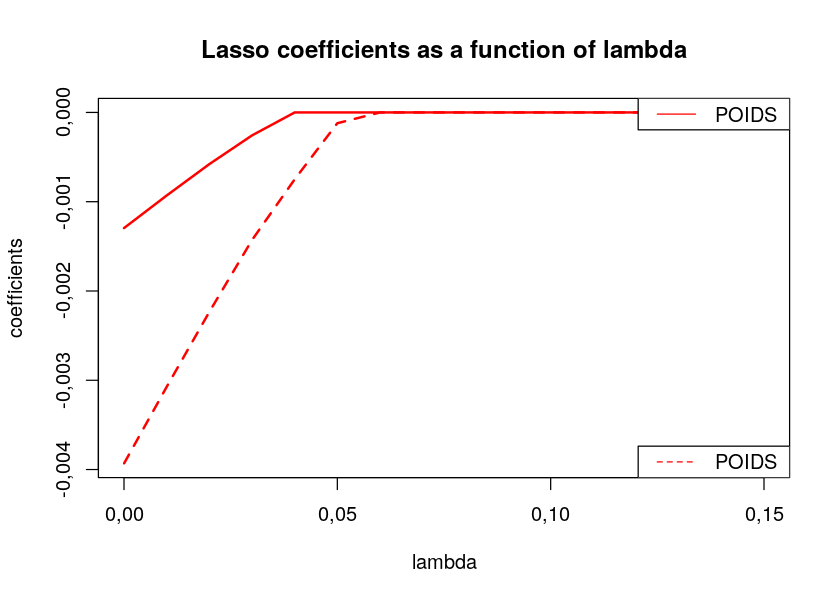

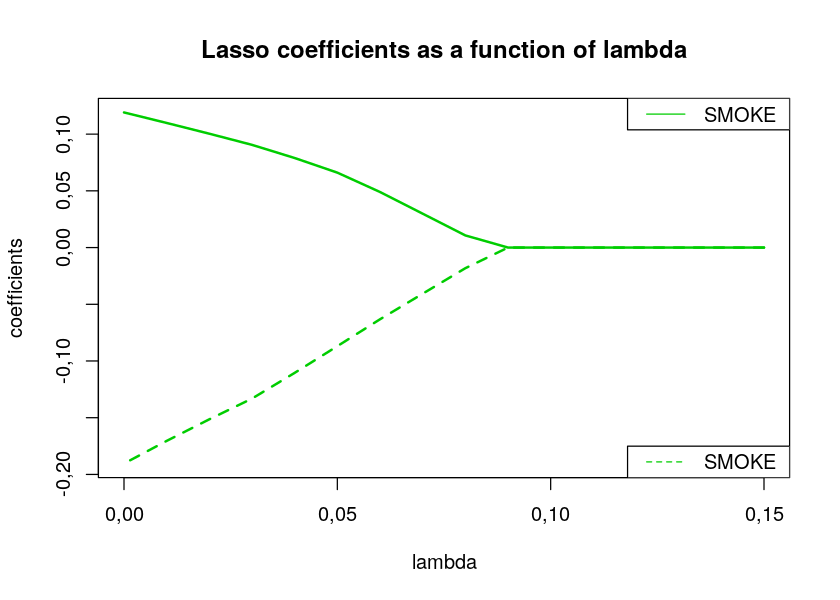

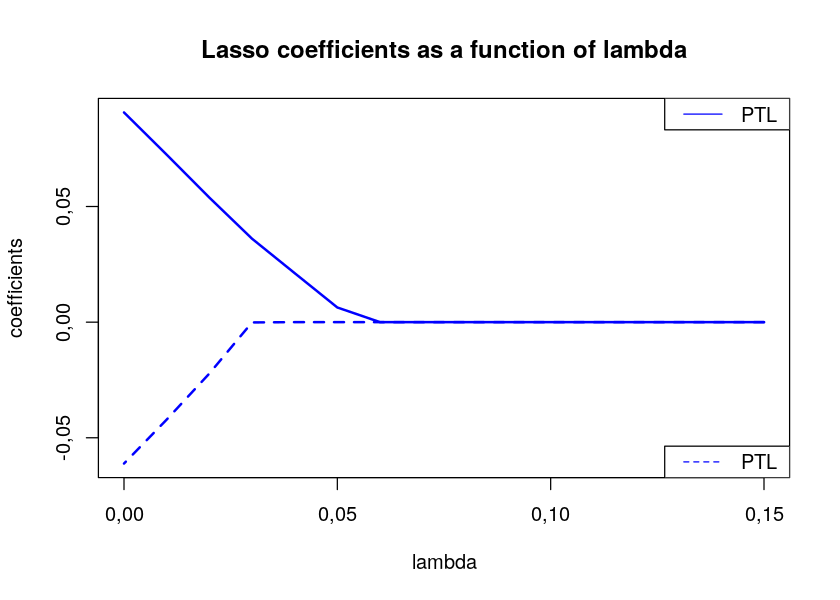

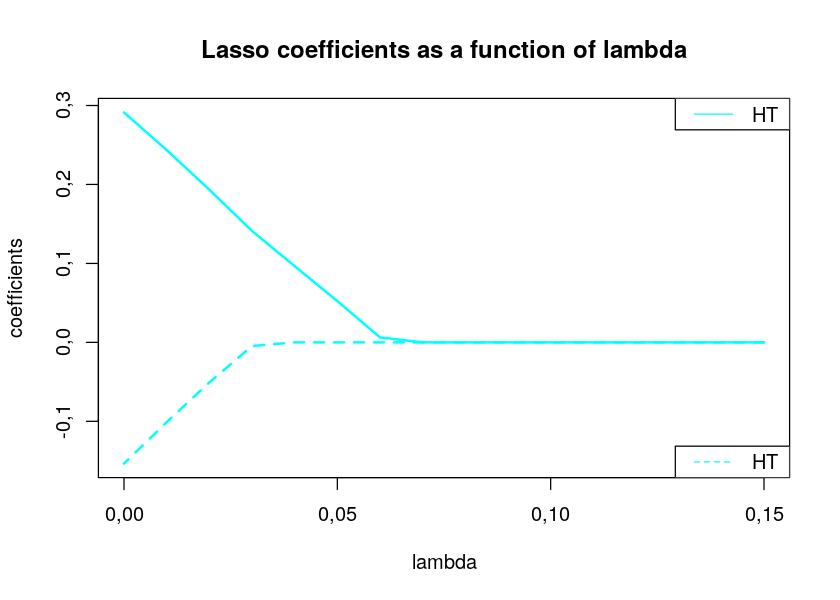

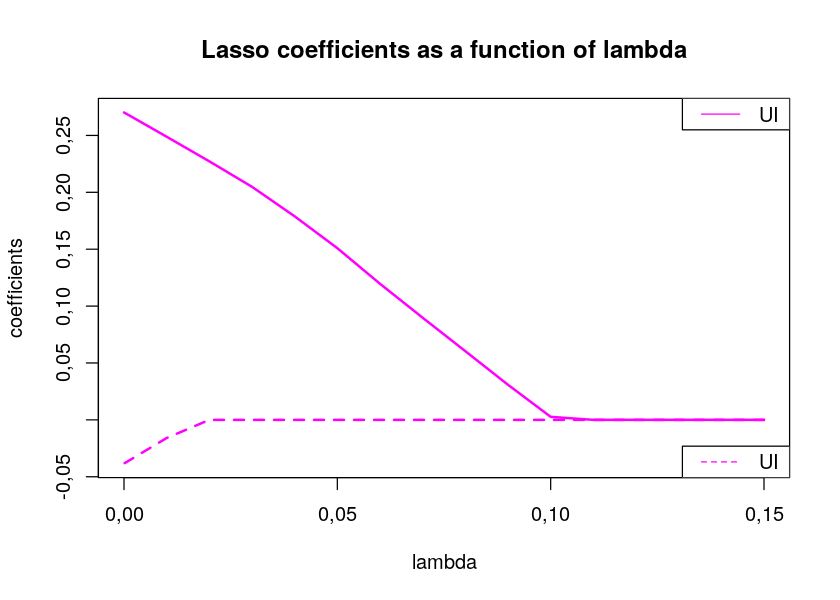

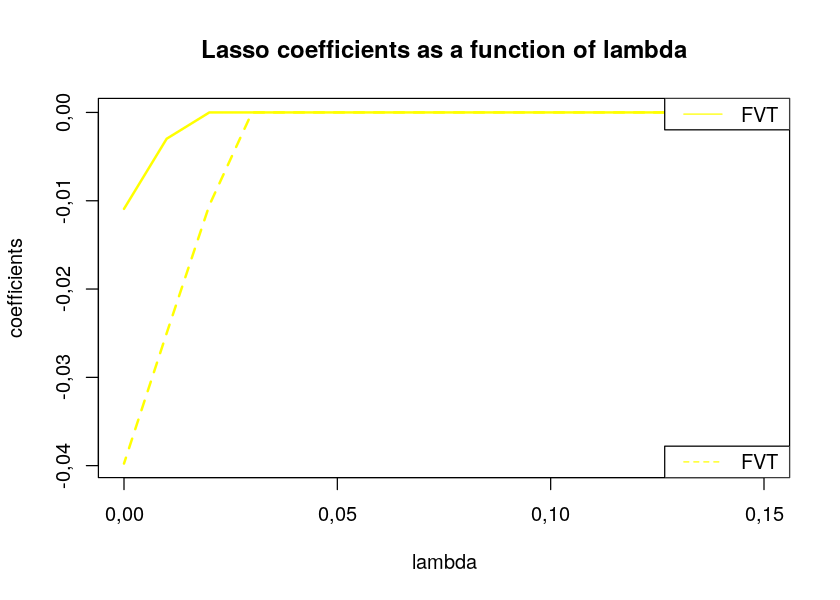

In [41]:
col_names = c('AGE', 'POIDS', 'SMOKE', 'PTL', 'HT', 'UI', 'FVT')

for (i in 1:7)
{
    matplot(fit_lasso_tot$lambda, t(fit_lasso_tot$beta[c(i,7+i),]), type="l", lty = 1:2,
        lwd = 2, col=col[i], xlab="lambda", ylab="coefficients",
        main="Lasso coefficients as a function of lambda")
    legend("topright", col_names[i], lwd=1, col=col[i])
    legend("bottomright", col_names[i], lty=2, col=col[i])
}

We can observe that the important variables are: `AGE`, `PTL`, `HT`, `UI` and maybe `SMOKE` (depending on the permutation).

---
Back to [top](#top).